# Inclusion Stress Field Prediction

Импортируем библиотеки:

In [1]:
import os
import glob

import cv2

import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_style('darkgrid')

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import models
from torchmetrics import MeanSquaredError
from torchmetrics import MeanAbsoluteError

from fastai.vision.learner import create_body
from fastai.vision.models.unet import DynamicUnet

import albumentations as A

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
torch.manual_seed(42)
cudnn.deterministic = True
cudnn.benchmark = False
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Обозначим константы:

In [2]:
#Model Constants
IMAGE_SIZE = 256
BATCH_SIZE = 5
LAMBDA_L1 = 100
LEARNING_RATE = 1e-2
EPOCH = 300
MODEL_NAME = 'DynamicUnet'

Основные пути к папкам, откуда мы будем брать исходные данные для данного проекта:

In [3]:
path_folder = 'S:/abaqus_job_files/plot\\'
path_table = 'S:/abaqus_job_files/stresses_data/general_array.csv'
path_inclusions_count = 'S:/abaqus_job_files/stresses_data/inclusions.csv'
path_radius = 'S:/abaqus_job_files/stresses_data/radius_array.csv'
path_model_save = 'S:/abaqus_job_files/models/'

## Работа с табличными данными

In [4]:
def data_preparation(path=path_folder,
                     path_array=path_table,
                     path_incl=path_inclusions_count,
                     path_rad=path_radius):
    
    plots = ['mises', 'geom']
    
    #read data
    df = pd.read_csv(path_array, delimiter=' ', header=0).round(2)
    df['inclusions'] = pd.read_csv(path_incl, delimiter=' ', header=0).round(0).values
    df['radius'] = pd.read_csv(path_rad, delimiter=' ', header=0).values
    df['area'] = (np.pi * (df['radius']) ** 2) * df['inclusions']
    df.index += 1
    
    for i in plots:

        raw_images = sorted(glob.glob(path + '/*' + i + '*'), key=len)
        df['images_' + i] = raw_images
    
    #df = df.dropna(axis=1)
    df_train, df_valid = train_test_split(df,
                                          train_size=.8,
                                          random_state=42,
                                          shuffle=True)
    
    print(f'Train shape: {df_train.shape[0]}')
    print(f'Valid shape: {df_valid.shape[0]}')
        
    return df_train, df_valid

Разделим данные на тренировочную, валидационную и тестовую выборки.

In [5]:
df_train, df_valid = data_preparation()

Train shape: 800
Valid shape: 200


In [6]:
df_train.head()

,max_stress,min_stress,inclusions,radius,area,images_mises,images_geom
30,139.83,95.60,11.0,0.574,11.385873,S:/abaqus_job_files/plot\30_mises.png,S:/abaqus_job_files/plot\30_geom.png
536,164.12,87.17,24.0,0.742,41.511548,S:/abaqus_job_files/plot\536_mises.png,S:/abaqus_job_files/plot\536_geom.png
696,131.88,91.16,11.0,0.779,20.970920,S:/abaqus_job_files/plot\696_mises.png,S:/abaqus_job_files/plot\696_geom.png
558,158.98,91.71,20.0,0.610,23.379733,S:/abaqus_job_files/plot\558_mises.png,S:/abaqus_job_files/plot\558_geom.png
837,163.74,89.45,23.0,0.825,49.179669,S:/abaqus_job_files/plot\837_mises.png,S:/abaqus_job_files/plot\837_geom.png


## EDA

Оценим распределение представленных величин.

In [7]:
def kde_plot(data_list):
    
    columns = ['max_stress', 'min_stress']
    
    fig, ax = plt.subplots(1, 2, figsize=(13, 7))
    
    for data in data_list:
        for column, i in zip(columns, [0, 1]):
            
            sns.kdeplot(x=column,
                        data=data,
                        shade=True,
                        ax=ax[i])
            
            if i == 0:
                ax[i].set_ylabel('Density', fontsize=12)
            else:
                ax[i].set_ylabel('')
                
            ax[i].set_xlabel(f'{column}')
            ax[i].set_title(f'KDE of {column}')
            ax[i].legend(['Train', 'Valid'])
    
    fig.suptitle(f'Kernel density estimation of min and max stress variables', fontsize=18)
    fig.tight_layout()
    plt.show()

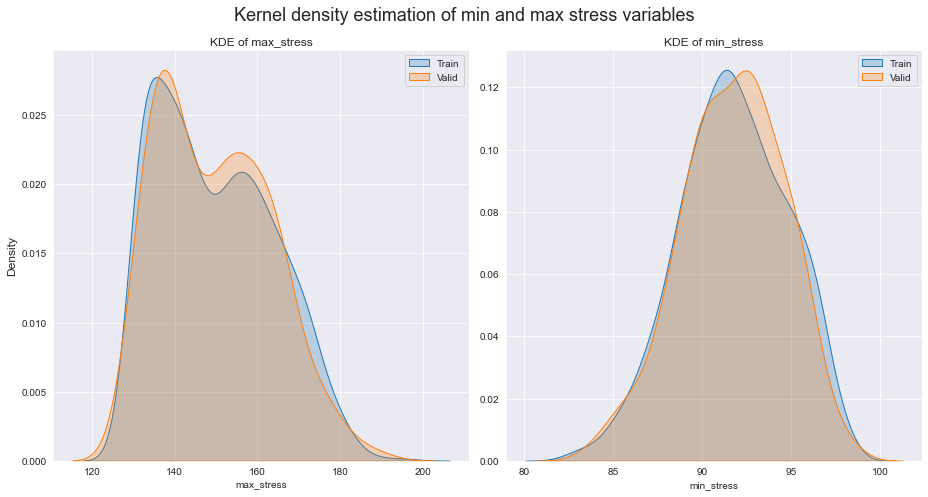

In [8]:
kde_plot([df_train, df_valid])

Распределения всех представленных величин крайне схожи по своей форме для различных наборов данных - тренировочного, валидационного и тестового датасетов.

## Загрузчик данных

Напишем загрузчик данных, который сможет выгружать датасеты по отдельным компонентам.

In [9]:
class StressDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, transform=None):
        
        self.df = df
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        
        #geometry preprocessing
        geometry = cv2.imread(self.df.iloc[index, -1], cv2.IMREAD_GRAYSCALE)
        #crop
        geometry = geometry[20:780, 331:1092]
        #resize
        geometry = cv2.resize(geometry, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normalize
        #geometry = (255 - geometry)
        geometry = cv2.threshold(geometry, 127, 255, cv2.THRESH_BINARY)[1]
        geometry = geometry / 255
        #add additional dimension
        geometry = np.array([geometry]).astype('float32')
          
        result = cv2.imread(self.df.iloc[index, -2], cv2.IMREAD_GRAYSCALE)
        #crop
        result = result[118:637, 523:1043]
        #resize image
        result = cv2.resize(result, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_CUBIC)
        #normolize between 0 and 1
        result = result / 255
        
        #normalize between min and max stresses
        result = cv2.normalize(
            result, None, alpha=self.df.iloc[index, 1], beta=self.df.iloc[index, 0], norm_type=cv2.NORM_MINMAX
        )
        result = np.array([result]).astype('float32')
        
        #augmentation
        if self.transform is not None:
            aug = self.transform(image=result, mask=geometry)
            result = aug['image']
            geometry = aug['mask']
        
        #convert to torch.Tensor
        geometry = torch.from_numpy(geometry.copy()).type(torch.float32)
        result = torch.from_numpy(result.copy()).type(torch.float32)
        
        return (geometry, result)

In [10]:
train_transform = A.Compose([
    A.HorizontalFlip(p=1),
    A.VerticalFlip(p=1)
])

Начнем работу с компоненты тензора напряжений - $\bf{\sigma_{11}}$.

In [11]:
train_dataset = StressDataset(df_train, transform=train_transform)
valid_dataset = StressDataset(df_valid)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [13]:
def image_show_tensor(dataloader, number_of_images=3, initial_index=0, values_name=None):
    
    masks, images = next(iter(dataloader))

    fig = plt.figure(figsize=(20, 20))
    
    for idx, tensor in enumerate([masks, images]):
        
        tensor = tensor.numpy().transpose(0,2,3,1)
        
        fig = plt.figure(figsize=(20, 20))
        
        for i in range(number_of_images):

            fig.add_subplot(1, number_of_images+1, i+1)
            
            min = (tensor[i+initial_index]).min()
            max = (tensor[i+initial_index]).max()
            
            if idx == 0:
                plt.imshow(tensor[i+initial_index], cmap='PuBu')
                plt.title(f'Geometry Inclusion={min:.0f}; Matrix={max:.0f}')
            else:
                plt.imshow(tensor[i+initial_index], cmap='icefire')
                plt.title(f'von Mises Stress Min={min:.2f}; Max={max:.2f}')

            plt.clim(min, max)
            plt.colorbar(shrink=0.2015)
            
            plt.xticks([])
            plt.yticks([])
            plt.tight_layout()
            
    plt.show()

<Figure size 1440x1440 with 0 Axes>

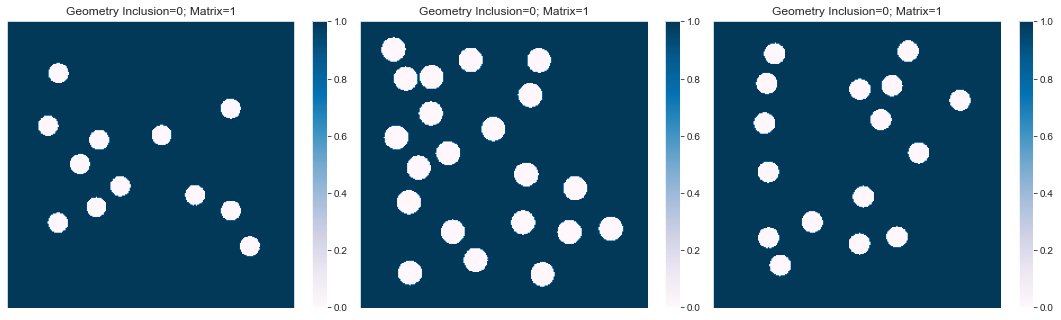

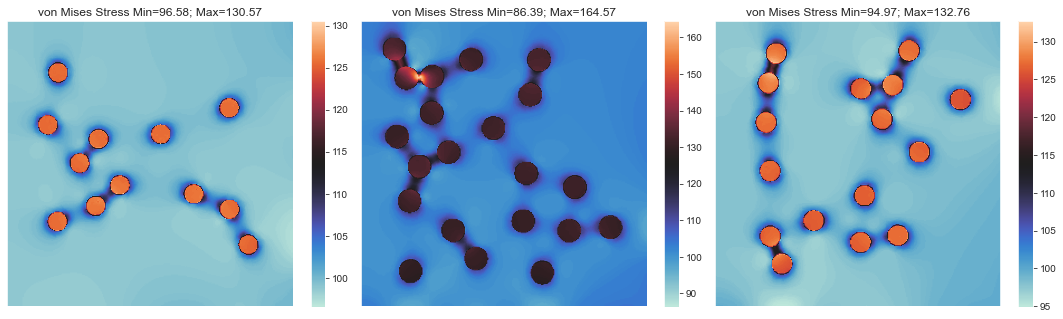

In [14]:
image_show_tensor(train_dataloader)

## Модель 

In [15]:
def build_res_unet(n_input=1, n_output=1, size=IMAGE_SIZE):
    body = create_body(models.resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size))
    return net_G

In [16]:
model = build_res_unet().to(device, dtype=torch.float)

Используем предобученную модель.

Обозначим дополнительную метрику оценки качества работы модели:

In [17]:
mean_squared_error = nn.MSELoss()

Определим **loss**-функцию и **optimizer**.

In [18]:
loss = nn.L1Loss()

In [19]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=0.0)

## Обучение

In [20]:
mae_train_loss_history, mae_valid_loss_history = [], []
mse_train_loss_history, mse_valid_loss_history = [], []

for epoch in range(EPOCH):
    
    mae_train_batch_loss_history, mae_valid_batch_loss_history = [], []
    mse_train_batch_loss_history, mse_valid_batch_loss_history = [], []
    
    #train
    model.train()
    for geometry, result in train_dataloader:
        
        optimizer.zero_grad()
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        pred = model(geometry)
        
        mae_train = loss(pred, result) 
        mse_train = mean_squared_error(pred, result)
        
        mae_train_batch_loss_history.append(mae_train.item())
        mse_train_batch_loss_history.append(mse_train.item())
        
        mae_train.backward()
        optimizer.step()
        
        del geometry, result
        torch.cuda.empty_cache()
        
    #valid
    model.eval()
    for geometry, result in valid_dataloader:
        
        geometry = geometry.to(device, dtype=torch.float)
        result = result.to(device, dtype=torch.float)
        
        pred = model(geometry)
        
        mae_valid = loss(pred, result) 
        mse_valid = mean_squared_error(pred, result)
        
        mae_valid_batch_loss_history.append(mae_valid.item())
        mse_valid_batch_loss_history.append(mse_valid.item())
        
        del geometry, result
        torch.cuda.empty_cache()
    
    mae_train_loss = np.mean(mae_train_batch_loss_history)
    mae_train_loss_history.append(mae_train_loss)
    mse_train_loss = np.mean(mse_train_batch_loss_history)
    mse_train_loss_history.append(mse_train_loss)
    
    mae_valid_loss = np.mean(mae_valid_batch_loss_history)
    mae_valid_loss_history.append(mae_valid_loss)
    mse_valid_loss = np.mean(mse_valid_batch_loss_history)
    mse_valid_loss_history.append(mse_valid_loss)

    print(
        f'{epoch} | MAE:{mae_train_loss:.4f} | MAE valid:{mae_valid_loss:.4f} | MSE:{mse_train_loss:.4f} | MSE valid:{mse_valid_loss:.4f}'
    )

0 | MAE:8626958423.7320 | MAE valid:7.1400 | MSE:14409583160465746296832.0000 | MSE valid:99.9513
1 | MAE:10.1687 | MAE valid:4.2111 | MSE:166.1753 | MSE valid:47.0087
2 | MAE:8.4081 | MAE valid:3.8046 | MSE:119.1347 | MSE valid:35.2529
3 | MAE:7.0938 | MAE valid:3.3570 | MSE:82.4397 | MSE valid:24.8396
4 | MAE:7.0681 | MAE valid:6.3713 | MSE:82.3178 | MSE valid:55.4388
5 | MAE:6.9676 | MAE valid:6.6795 | MSE:82.0058 | MSE valid:57.2622
6 | MAE:7.3801 | MAE valid:2.9368 | MSE:87.9434 | MSE valid:17.0571
7 | MAE:6.9267 | MAE valid:2.9703 | MSE:83.3995 | MSE valid:17.4673
8 | MAE:6.3637 | MAE valid:5.5756 | MSE:68.6547 | MSE valid:41.2094
9 | MAE:5.5804 | MAE valid:5.7969 | MSE:50.2956 | MSE valid:43.3731
10 | MAE:4.9320 | MAE valid:3.2635 | MSE:40.8968 | MSE valid:19.6425
11 | MAE:4.0400 | MAE valid:3.4551 | MSE:27.0982 | MSE valid:18.9318
12 | MAE:3.4469 | MAE valid:3.9026 | MSE:20.9739 | MSE valid:22.7020
13 | MAE:3.6813 | MAE valid:2.8744 | MSE:23.5844 | MSE valid:15.5257
14 | MAE:3.

121 | MAE:1.7719 | MAE valid:2.0927 | MSE:6.5555 | MSE valid:8.2575
122 | MAE:1.8403 | MAE valid:1.8895 | MSE:6.9522 | MSE valid:6.8316
123 | MAE:1.7753 | MAE valid:1.7477 | MSE:6.6828 | MSE valid:6.1552
124 | MAE:1.9071 | MAE valid:1.7948 | MSE:7.4148 | MSE valid:6.7997
125 | MAE:1.8298 | MAE valid:2.0245 | MSE:6.8531 | MSE valid:8.7841
126 | MAE:1.7088 | MAE valid:1.7977 | MSE:6.1966 | MSE valid:6.3110
127 | MAE:1.7135 | MAE valid:1.7536 | MSE:6.1899 | MSE valid:6.5369
128 | MAE:1.7606 | MAE valid:1.7935 | MSE:6.5151 | MSE valid:6.7072
129 | MAE:1.7922 | MAE valid:1.7662 | MSE:6.6364 | MSE valid:6.2394
130 | MAE:1.8750 | MAE valid:1.7505 | MSE:7.2502 | MSE valid:6.4158
131 | MAE:1.7288 | MAE valid:1.9630 | MSE:6.2629 | MSE valid:7.2026
132 | MAE:1.7454 | MAE valid:1.9979 | MSE:6.3998 | MSE valid:7.7511
133 | MAE:1.7773 | MAE valid:1.7236 | MSE:6.5375 | MSE valid:6.0614
134 | MAE:1.7701 | MAE valid:2.0744 | MSE:6.4504 | MSE valid:8.5040
135 | MAE:1.7468 | MAE valid:1.7185 | MSE:6.3144

242 | MAE:1.5181 | MAE valid:1.8395 | MSE:4.7339 | MSE valid:6.7712
243 | MAE:1.6485 | MAE valid:1.9140 | MSE:6.6044 | MSE valid:7.1680
244 | MAE:1.6391 | MAE valid:1.6914 | MSE:5.4377 | MSE valid:5.4246
245 | MAE:1.5603 | MAE valid:1.7464 | MSE:4.9116 | MSE valid:5.5523
246 | MAE:1.6004 | MAE valid:1.6639 | MSE:5.3157 | MSE valid:5.0876
247 | MAE:1.5640 | MAE valid:1.7678 | MSE:5.0334 | MSE valid:6.1977
248 | MAE:1.5536 | MAE valid:1.6668 | MSE:4.9207 | MSE valid:5.2523
249 | MAE:1.5288 | MAE valid:1.7819 | MSE:4.7525 | MSE valid:5.9572
250 | MAE:1.5641 | MAE valid:1.6854 | MSE:5.0137 | MSE valid:5.3131
251 | MAE:1.5465 | MAE valid:1.6930 | MSE:4.9145 | MSE valid:5.5351
252 | MAE:1.5850 | MAE valid:1.7664 | MSE:5.1968 | MSE valid:6.0739
253 | MAE:1.5407 | MAE valid:1.7485 | MSE:4.9335 | MSE valid:5.7116
254 | MAE:1.5418 | MAE valid:1.8718 | MSE:4.9067 | MSE valid:7.3444
255 | MAE:1.6199 | MAE valid:1.7208 | MSE:5.5082 | MSE valid:5.5551
256 | MAE:1.5348 | MAE valid:2.1646 | MSE:4.8360

Сохраним полученную модель генератора.

In [21]:
torch.save(model, path_model_save + 'vonMises' + MODEL_NAME)

## Результаты 

Отдельно сохраним результаты обучения модели.

In [22]:
dict_data = {'MAE Train' : mae_train_loss_history,
             'MAE Valid' : mae_valid_loss_history,
             'MSE Train' : mse_train_loss_history,
             'MSE Valid' : mse_valid_loss_history}

In [23]:
df_results = pd.DataFrame.from_dict(dict_data)
df_results.to_csv('S:/abaqus_job_files/results_data/loss_results_vonMises_' + MODEL_NAME + '.csv', sep=' ')

In [24]:
def loss_plot(data):
    
    mae_loss_names = data.columns[:2]
    mse_loss_names = data.columns[2:]
    legend_names = ['Train', 'Valid']
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, j, k in zip(mae_loss_names, mse_loss_names, legend_names):
        
        ax[0].plot(data[i].values, label=k)
        ax[1].plot(data[j].values, label=k)
        
    for i, j in enumerate(['MAE', 'MSE']):

        ax[i].set_title(f'{j} Loss Plot', fontsize=14)
        ax[i].set_xlabel('Epoch', fontsize=12)
        ax[i].set_ylabel(f'{j} Loss Function Value', fontsize=12)
        ax[i].legend()
        
    fig.suptitle('Loss functions plot for von Mises', fontsize=18)
    plt.show()

Визуализируем значения функции потерь для каждого из датасетов.

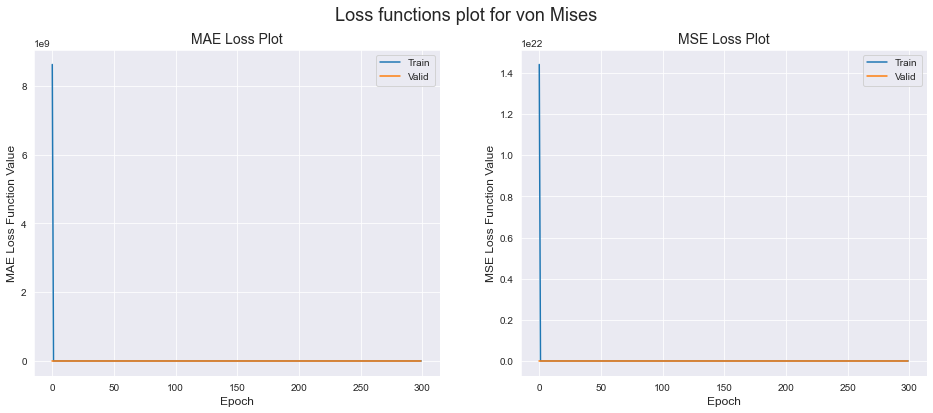

In [25]:
loss_plot(df_results)

Визуально оценим результаты работы алгоритма.

In [26]:
def singular_result(dataloader, model=model, initial_index=0, cmap='icefire', component='von Mises Stress'):
    
    model.eval()
    model = model.cpu()
    geometry, result = next(iter(dataloader))

    prediction = model(geometry.float())
    error = abs(result - prediction)

    tensors = [geometry, result, prediction, error]
    titles = ['Geometry', f'True {component} field', f'Predicted {component} field', '$L_{1}$ error']
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 12))
    
    for tensor, title, i, j in zip(tensors, titles, [0, 0, 1, 1], [0, 1, 0, 1]): 
        
        tensor = tensor.cpu().detach().numpy().transpose(0,2,3,1)
        
        if i == 0 and j == 0:
            img = ax[i, j].imshow(tensor[initial_index], cmap='PuBu')
        elif i != j:
            img = ax[i, j].imshow(tensor[initial_index], cmap=cmap)
        else:
            img = ax[i, j].imshow(tensor[initial_index], cmap='coolwarm')
            
        ax[i, j].set_title(title, fontsize=14)
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        
        min = (tensor[initial_index]).min()
        max = (tensor[initial_index]).max()
        
        if i == 1 and j == 1:
            img.set_clim(0, max)
        else:
            img.set_clim(min, max)
            
        plt.colorbar(img, shrink=0.815, ax=ax[i, j])
            
    fig.suptitle(f'Visualization for the one sample of {component}', fontsize=18)
    fig.tight_layout()
    plt.show()

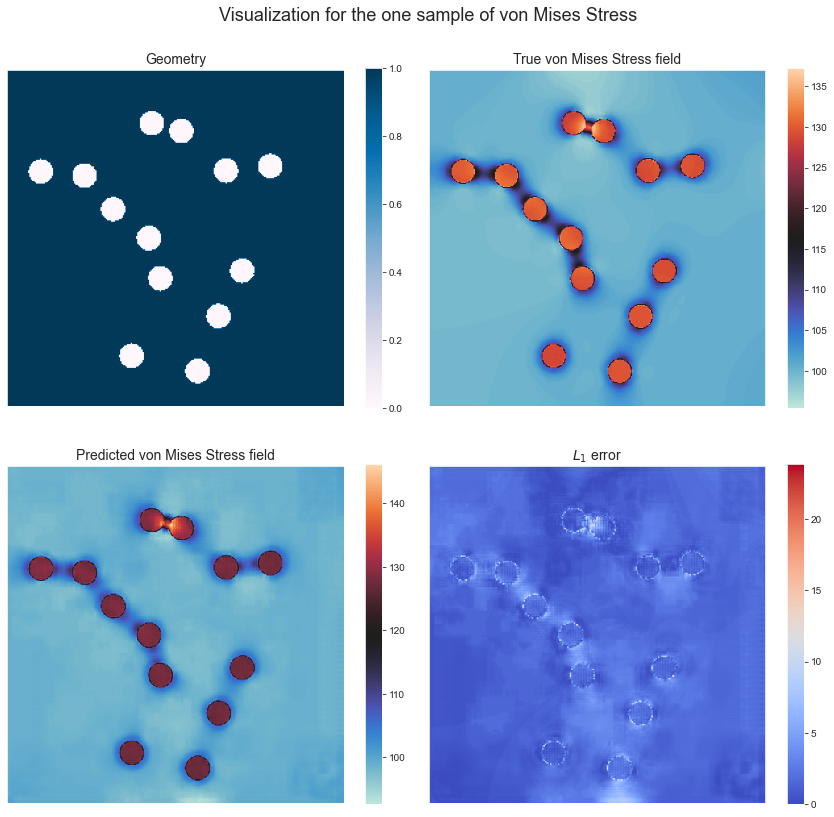

In [27]:
singular_result(valid_dataloader)